# Physics-Informed Neural Networks: Burgers Equation

In [ ]:
# Run this if in colab to install DeepXDE
!pip install deepxde --quiet

# Remember to change the Runtime to GPU for better performance
!python -m deepxde.backend.set_default_backend pytorch

## Motivation

For years mathematicians and physicists are trying to model the world with differential equations. However, since the advent of techniques such as machine learning, neural networks and deep learning together with greater computing power, community has speculated that we could learn automatically (algorithms) anything with a enough amount of data. However, it seems this is not really true.

Philosophical Question: Could have a _machine_ discovered Newton's laws?

#### PINNs

In 2019, Raissi, Perdikaris and Karniadakis introduced Physics-Informed Neural Networks (PINNs), neural networks that are trained to solve supervised learning tasks while respecting any given law of physics described by general nonlinear partial differential equations ([source](https://www.sciencedirect.com/science/article/pii/S0021999118307125)). PINNs are nowadays used to solve PDEs, fractional equations, and integral-differential equations.

__Idea__

PINNs approximate PDE solutions by training a neural network to minimize a loss function, including:

* Initial and boundary conditions along the space-time domain’s boundary
* PDE residual at selected points in the domain.

If you want to do a simplified analogy, initial and boundary conditions points will be an usual training dataset, but also it is necessary to embed physical laws (PDE) into the neural network.

## Setup

PINNs can solve differential equations expressed, in the most general form, like:

$$
\begin{align*}
\mathcal{F}(u(z); \lambda) &= f(z) \quad z \text{ in } \Omega \\
\mathcal{B}(u(z)) &= g(z) \quad z \text{ in } \partial \Omega
\end{align*}
$$ 

defined on the domain $\Omega \subset \mathbb{R}^d$ with the boundary $\partial \Omega$. Where
- $z := (x_1, x_2, \ldots, t)^\top$ indicated the space-time coordinate vector,
- $u$ the unknown function,
- $\lambda$ the parameters related to the physics,
- $\mathcal{F}$ the non-linear differential operator,
- $f$ the function identifying the data of the problem,
- $\mathcal{B}$ the operator indicating arbitrary initial or boundary conditions, and
- $g$ the boundary function.

In the PINN methodology, $u(z)$ is computationally predicted by a NN, parametrized by a set of parameters $\theta$, giving rise to an approximation
$$
\hat{u}_\theta(z) \approx u(z)
$$

The optimization problem we want to deal with it is

$$
\min_\theta \; \omega_\mathcal{F} \mathcal{L}_\mathcal{F}(\theta) + \omega_\mathcal{B} \mathcal{L}_\mathcal{B}(\theta) + \omega_{\text{data}} \mathcal{L}_{\text{data}}(\theta)
$$

this is three weighted loss functions, each one depending on
- $\mathcal{L}_\mathcal{F}$, differential equation, 
- $\mathcal{L}_\mathcal{B}$, boundary conditions, and
- $\mathcal{L}_{\text{data}}$, (eventually) some known data.

![PINNs](../images/info_pinn.png)

[Source](https://link.springer.com/article/10.1007/s10915-022-01939-z)

For the implementation, we use the Python package [DeepXDE](https://deepxde.readthedocs.io/en/latest/), which is has been developed specifically for scientific machine learning and physics-informed learning. It support several tensor libraries as backend (TensorFlow, PyTorch, JAX, among other).

One of its main features is that enables the user code to be compact, resembling closely the mathematical formulation. We don't have to worry much about the technical aspect of the code, but rather about the mathematical model.

## Burgers Equation

We will solve a Burqers equation

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2u}{\partial x^2}, \qquad x \in [-1, 1], \quad t \in [0, 1]
$$
with the Dirichlet boundary conditions and initial conditions
$$
u(-1,t)=u(1,t)=0, \quad u(x,0) = - \sin(\pi x).
$$
and $\nu = 0.01 / \pi$.

Let's start importing our packages, `numpy` is for numerical operations and `matplotlib` for plotting. Also notice we import `torch` from `deepxde` since it is the tensor backend we are going to use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

from scipy.integrate import odeint
from deepxde.backend import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## FFT Solver

First, we will estimate numerically the solution using Fast Fourier Transform to solve a ordinary differential equations at the end. Let's define the spatial and temporal meshes, as well as the initial conditions and $\nu$.

In [2]:
# Spatial mesh
L_x = 1  # Range of the domain according to x
dx = 0.001  # Infinitesimal distance
x_train = np.arange(-L_x, L_x + dx, dx)  # Spatial array

# Temporal mesh
L_t = 1  # Duration of simulation
dt = 0.0025   # Infinitesimal time
t_train = np.arange(0, L_t + dt, dt)  # Temporal array

# Initial condition
u0 = - np.sin(np.pi * x_train)

# Parameters
nu = 0.01 / np.pi # Kinematic viscosity coefficient

The idea of FFT is to obtain the spatial derivatives and then we only need to get the residual respecto to time.

In [4]:
#Definition of ODE system (PDE ---(FFT)---> ODE system)
def burg_system(u, t, k, nu):
    #Spatial derivative in the Fourier domain
    u_hat = np.fft.fft(u)
    u_hat_x = 1j * k * u_hat
    u_hat_xx = -k ** 2 * u_hat

    #Switching in the spatial domain
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)

    #ODE resolution
    u_t = -u * u_x + nu * u_xx
    return u_t.real

Now the solution can be obtained solving the ODE using `scipy.integrate.odeint` which uses a Runge-Kutta.

In [5]:
k = 2 * np.pi * np.fft.fftfreq(len(x_train), d=dx) # Wave number discretization
u_fft = odeint(burg_system, u0, t_train, args=(k, nu))  # Solver

With the solution `u_fft` we can plot the results.

Text(0.5, 1.0, 'Numerical Solution of Burgers Eq. based on FFT')

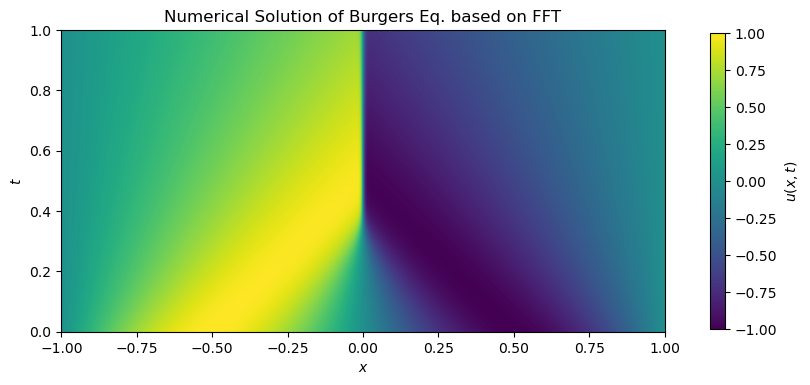

In [11]:
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")
im = ax.imshow(u_fft, origin="lower", extent=[-L_x, L_x, 0, L_t])
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("$u(x, t)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title("Numerical Solution of Burgers Eq. based on FFT")
# fig.savefig("burgers_fft_forward.png", dpi=300)  # Uncomment if you want to save the figure.

## PINNs Forward

The first step is to define the domain, which is done with a spatial and temporal domain.

In [12]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

The PDE residual is

$$
\mathcal{L}_{\mathcal{F}}(\theta) =
\frac{\partial \hat{u}_\theta}{\partial t} + \hat{u}_\theta\frac{\partial \hat{u}_\theta}{\partial x} - \nu\frac{\partial^2 \hat{u}_\theta}{\partial x^2}
$$
which can be coded in a few lines.

In [14]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)  # j=0 corresponds to the variable $x$
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)  # j=1 corresponds to the variable $t$
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - nu * dy_xx

Notice that the first argument `x` of the function `ode` corresponds to the input. This could potentially be missleading, since in this case the array `x` has two columns, which correspond to the input variables $(x, t)$. The argument `y` has the solution values, in this case it is only a column vector for $u(x, t)$. In the case you have multiple equations then `y` will have more columns.

The next step is to define the boundary and initial conditions, using the module `deepxde.icbc`. Here we use explicitly the domain `geomtime` define previously.

In [15]:
bc = dde.icbc.DirichletBC(
    geomtime,
    lambda x: 0,
    lambda _,
    on_boundary: on_boundary
)
ic = dde.icbc.IC(
    geomtime,
    lambda x: -np.sin(np.pi * x[:, 0:1]),
    lambda _,
    on_initial: on_initial
)

Finally, everything related to the equation is putting together in a single `deepxde.data.TimePDE` object. The first argument is the domain, the second one the differential residual, then the initial and boundary conditions. If we were working with observed data it should be in this list as well.

In [16]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160
)

Here, the last three arguments corresponds to
- `num_domain`: the number of training residual points sampled inside the domain,
- `num_boundary`: the number of training points sampled on the boundary, and
- `num_initial`: the number of residual points for the initial conditions.

Since we define all the elements of the diferential equations now we need to declare the architecture of the network. We will do a simple fully connected neural network `deepxde.nn.FNN` with 3 hidden layers and 32 neurons each. As activation function we chose $\tanh$ and the initialization will be done using Glorot (or Xavier) Normal. Notice since we only have two indepent variables $(x, t)$ then the input layer has two neurons. Similar for the output layer, $u(x,t)$ is one-dimensional, then only one neuron is needed.

In [11]:
net = dde.nn.FNN([2] + [32] * 3 + [1], "tanh", "Glorot normal")

Finally, we put everything together in a `deepxde.Model` object, compile the model a optimizer, in this case Adams with a learning rate of 0.001. With all this, we can train the model for as many iterations we want.

In [20]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=30000)

Compiling model...
'compile' took 0.000233 s

Training model...

0         [5.61e-04, 1.39e-06, 3.87e-04]    [5.61e-04, 1.39e-06, 3.87e-04]    []  
1000      [5.29e-04, 1.30e-06, 3.71e-04]    [5.29e-04, 1.30e-06, 3.71e-04]    []  
2000      [5.02e-04, 1.26e-06, 3.46e-04]    [5.02e-04, 1.26e-06, 3.46e-04]    []  
3000      [4.71e-04, 1.22e-06, 3.24e-04]    [4.71e-04, 1.22e-06, 3.24e-04]    []  
4000      [4.37e-04, 1.17e-06, 3.02e-04]    [4.37e-04, 1.17e-06, 3.02e-04]    []  
5000      [4.81e-04, 1.52e-06, 2.96e-04]    [4.81e-04, 1.52e-06, 2.96e-04]    []  
6000      [4.20e-04, 9.99e-07, 2.72e-04]    [4.20e-04, 9.99e-07, 2.72e-04]    []  
7000      [3.43e-04, 9.12e-07, 2.50e-04]    [3.43e-04, 9.12e-07, 2.50e-04]    []  
8000      [3.18e-04, 9.59e-07, 2.36e-04]    [3.18e-04, 9.59e-07, 2.36e-04]    []  
9000      [2.97e-04, 1.53e-06, 2.25e-04]    [2.97e-04, 1.53e-06, 2.25e-04]    []  
10000     [2.73e-04, 8.67e-07, 2.11e-04]    [2.73e-04, 8.67e-07, 2.11e-04]    []  
11000     [2.55e-04, 7

We can even take this trained model and apply another optimizer on top of this! For example LBGGS, however it could take a lot of time to converge. Some researchers train with Adams with several thousands of iterations and then perform a LBFGS.

In [21]:
# model.compile("L-BFGS-B")
# losshistory, train_state = model.train()

Let's use this trained model for making predictions

In [35]:
xx, tt = np.meshgrid(x_train, t_train)  # Creates a mesh of values
X = np.vstack((np.ravel(xx), np.ravel(tt))).T  # Creates an array of two columns
u_pinn_vector = model.predict(X)  # Makes prediction
u_pinn = u_pinn_vector.reshape(len(t_train), len(x_train))  # Reshape for plotting purposes
res = model.predict(X, operator=pde)  # Residual is computed using operator=pde
print("Mean residual:", np.mean(np.absolute(res)))
print("L2 relative error:", dde.metrics.l2_relative_error(u_fft, u_pinn))

Mean residual: 0.007748898
L2 relative error: 0.014771619796036133


Also we can plot it in a similar way than before.

Text(0.5, 1.0, 'Numerical Solution of Burgers Eq. with PINNs')

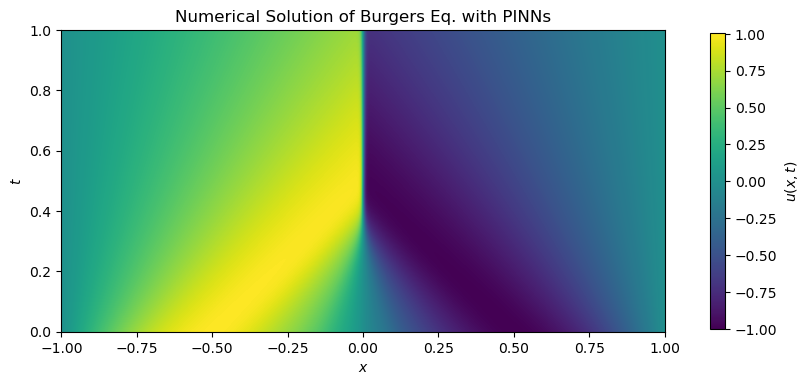

In [27]:
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")
im = ax.imshow(u_pinn, origin="lower", extent=[-L_x, L_x, 0, L_t])
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("$u(x, t)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title("Numerical Solution of Burgers Eq. with PINNs")
# fig.savefig("burgers_pinn_forward.png", dpi=300)

But since we have the residual we can explore where the framework is doing a good job!

Text(0.5, 1.0, 'Differential residual of solution of Burgers Eq. with PINNs')

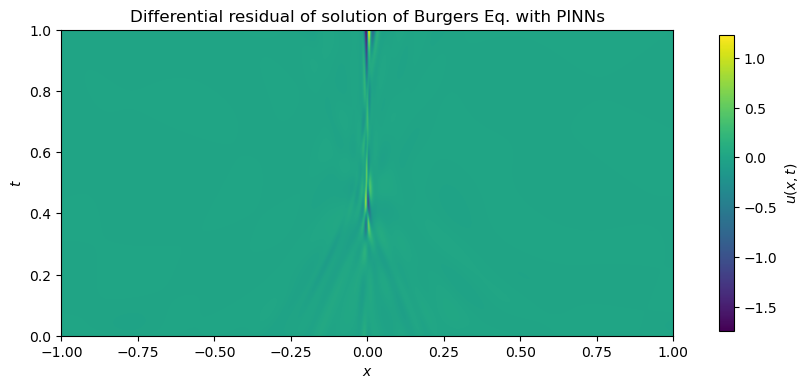

In [31]:
residual = res.reshape(len(t_train), len(x_train))
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")
im = ax.imshow(residual, origin="lower", extent=[-L_x, L_x, 0, L_t])
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("$u(x, t)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title("Differential residual of solution of Burgers Eq. with PINNs")
# fig.savefig("burgers_pinn_forward_res.png", dpi=300)

We can compare both solutions in a similar plot

Text(0.5, 1.0, 'Absolute error of Burgers Eq. between FFT and PINNs methods')

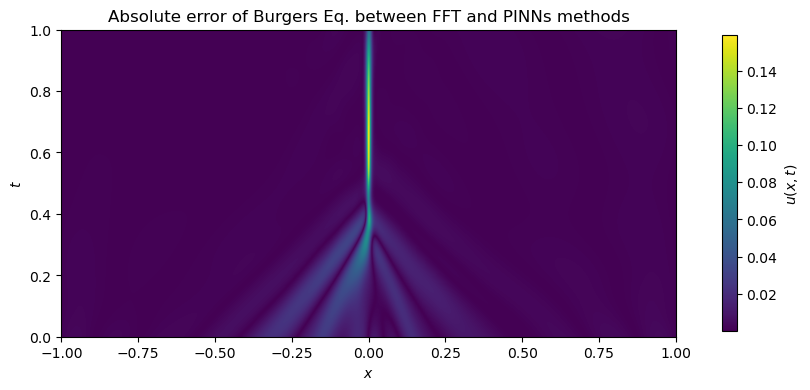

In [32]:
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")
im = ax.imshow(np.abs(u_pinn - u_fft), origin="lower", extent=[-L_x, L_x, 0, L_t])
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("$u(x, t)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title("Absolute error of Burgers Eq. between FFT and PINNs methods")
# fig.savefig("burgers_fft_vs_pinn_forward.png", dpi=300)

## PINNs Inverse

What if we don't know the value of $\nu$ but we have some observed/sampled data? We can use it to estimte $\nu$! The framework is almost identical. Since we don't have any data, we  will use the fast fourier transform solution as observed data but we will apply 1% of noise to it.

In [36]:
u_fft_vector = u_fft.reshape(-1, 1, order="F")

noise = 0.01
noise_vector = np.random.normal(scale=u_fft_vector.std(axis=0), size=u_fft_vector.shape)
u_noise_vector = u_fft_vector + noise * noise_vector


Domain is declared in the same way as before

In [40]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

We need to tell PINNs to also consider $\nu$ as a learnable parameter, for that we first declare it as a variable object with some initial guess.

In [41]:
nu_var = dde.Variable(0.01)

Now the differential residuals is almost idential

In [42]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    my_nu = (torch.tanh(nu_var) + 1) / 2
    return dy_t + y * dy_x - my_nu * dy_xx

Similar with the boundary and initial conditions

In [43]:
bc = dde.icbc.DirichletBC(
    geomtime,
    lambda x: 0,
    lambda _,
    on_boundary: on_boundary
)
ic = dde.icbc.IC(
    geomtime,
    lambda x: -np.sin(np.pi * x[:, 0:1]),
    lambda _,
    on_initial: on_initial
)

However, since we have observed data, we need to declare it using another class of objects. Notice you give as first argument the points where it was sampled.

In [44]:
observed_data = dde.icbc.PointSetBC(X, u_noise_vector, component=0)

Now, similar than before, we put everything together, with the difference that now we include the observed data and in the compilation step we need to explicitely tell the algorithm to learn external variables, in our case, only $\nu$.

In [47]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observed_data],  # It include the observed data
    # num_domain=512,
    # num_boundary=100,
    # num_initial=100,
    anchors=X,
    num_test=1000,
)

net = dde.nn.FNN([2] + [32] * 3 + [1], "tanh", "Glorot normal")
model_inv = dde.Model(data, net)
model_inv.compile(
    "adam",
    lr=1e-3,
    external_trainable_variables=nu_var  # For learning $\nu$
)
variable = dde.callbacks.VariableValue(nu_var, period=1000)  # Keep track of the variable estimation
losshistory, train_state = model_inv.train(iterations=20000, callbacks=[variable])

Compiling model...
'compile' took 0.000156 s

Training model...

0         [2.06e-01, 6.02e-02, 5.12e-01, 5.28e-01]    [2.05e-01, 6.02e-02, 5.12e-01, 5.28e-01]    []  
0 [9.33e-01]
1000      [7.72e-03, 1.33e-02, 7.44e-03, 3.53e-01]    [6.97e-03, 1.33e-02, 7.44e-03, 3.53e-01]    []  
1000 [6.66e-01]
2000      [6.57e-03, 1.75e-02, 6.17e-03, 3.36e-01]    [6.04e-03, 1.75e-02, 6.17e-03, 3.36e-01]    []  
2000 [1.27e+00]
3000      [6.31e-03, 2.26e-02, 5.60e-03, 3.25e-01]    [5.94e-03, 2.26e-02, 5.60e-03, 3.25e-01]    []  
3000 [1.69e+00]
4000      [5.86e-03, 2.74e-02, 5.47e-03, 3.15e-01]    [5.48e-03, 2.74e-02, 5.47e-03, 3.15e-01]    []  
4000 [2.05e+00]
5000      [5.40e-03, 3.05e-02, 4.56e-03, 3.08e-01]    [5.19e-03, 3.05e-02, 4.56e-03, 3.08e-01]    []  
5000 [2.38e+00]
6000      [4.79e-03, 3.32e-02, 4.42e-03, 3.04e-01]    [4.71e-03, 3.32e-02, 4.42e-03, 3.04e-01]    []  
6000 [2.68e+00]
7000      [4.69e-03, 3.40e-02, 4.37e-03, 3.03e-01]    [4.63e-03, 3.40e-02, 4.37e-03, 3.03e-01]    []  
70

Now, as the forward problem, we can predict and plot the results

In [48]:
u_pinn_inv = model_inv.predict(X).reshape(len(t_train), len(x_train))

Text(0.5, 1.0, 'Differential residual of solution of Burgers Eq. with PINNs Inverse')

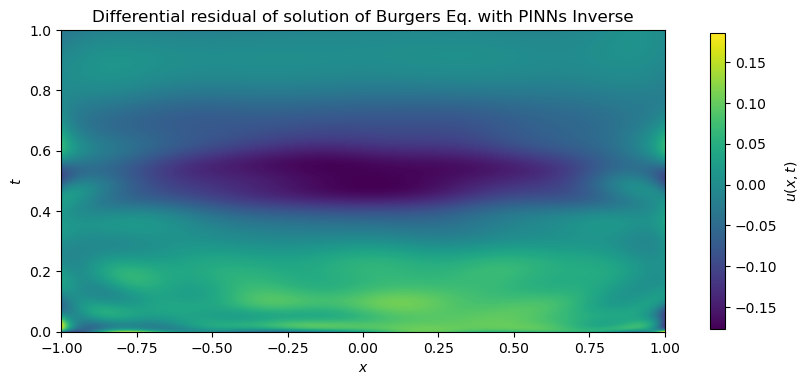

In [49]:
f_inv = model_inv.predict(X, operator=pde)
residual_inv = f_inv.reshape(len(t_train), len(x_train))
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")
im = ax.imshow(residual_inv, origin="lower", extent=[-L_x, L_x, 0, L_t])
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("$u(x, t)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title("Differential residual of solution of Burgers Eq. with PINNs Inverse")
# fig.savefig("burgers_pinn_inverse_res.png", dpi=300)

Text(0.5, 1.0, 'Numerical Solution of Burgers Eq. with PINNs Inverse')

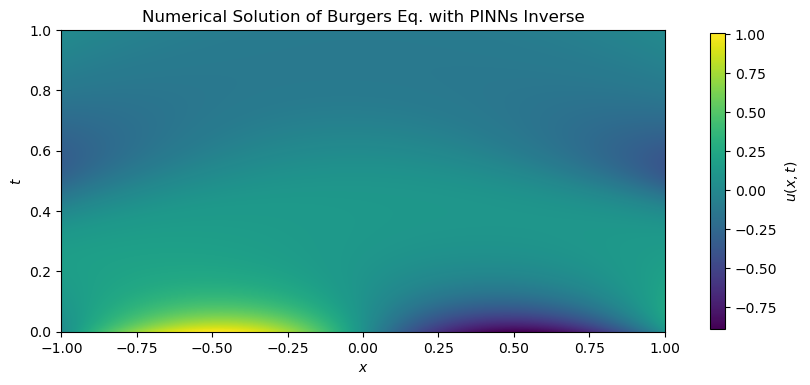

In [50]:
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")
im = ax.imshow(u_pinn_inv, origin="lower", extent=[-L_x, L_x, 0, L_t])
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("$u(x, t)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title("Numerical Solution of Burgers Eq. with PINNs Inverse")
# fig.savefig("burgers_pinn_inverse.png", dpi=300)

Text(0.5, 1.0, 'Absolute error of Burgers Eq. between FFT and PINNs Inverse methods')

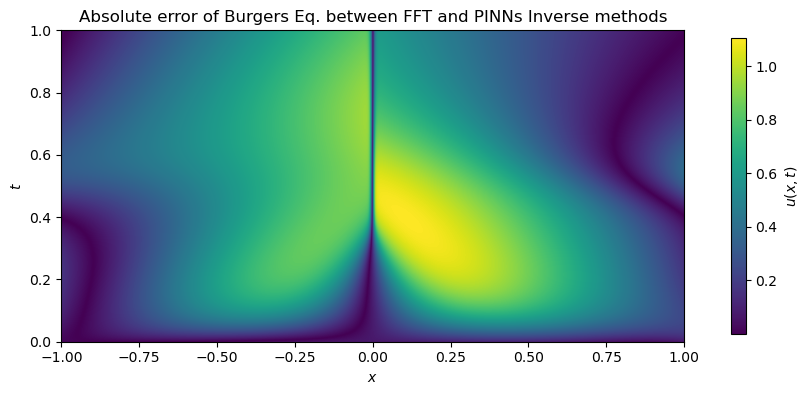

In [51]:
fig, ax = plt.subplots(figsize=(8, 6), layout="constrained")
im = ax.imshow(np.abs(u_pinn_inv - u_fft), origin="lower", extent=[-L_x, L_x, 0, L_t])
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("$u(x, t)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_title("Absolute error of Burgers Eq. between FFT and PINNs Inverse methods")
# fig.savefig("burgers_pinn_inverse_error.png", dpi=300)